In [163]:
# Imports
import os
import json
import time
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import copy
import fiona
import requests
import re
import folium.folium

import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as cx
import pmdarima as pm
import seaborn as sns

from tqdm import tqdm
from shapely.geometry import Polygon, Point
from geopandas.explore import _categorical_legend
from folium.plugins import Geocoder
from matplotlib.colors import rgb2hex

In the first part of this analysis, an estimated metric of smoke impact on the city of Shreveport will be devised, and a time series model will be developed to forecast this metric into the next 25 years. This smoke estimate will be compared alongside an estimate of daily and yearly AQI in Shreveport in order to both validate the effectiveness of estimated smoke impact and to highlight the ways in which AQI fails as a measurement of wildfire smoke pollution.

# Part 1: Air Quality Estimation

In order to understand the effectiveness of our analysis' future estimates of smoke impact, it is essential that we first prepare an estimate of the AQI for our city of interest. This AQI shall serve as a point of reference for future analysis. In order to obtain this, we will use the EPA's AQS API, a service that provides historical air quality data for areas across the country. This data is obtained from the various monitoring stations across the U.S. and is associated with given regions by the EPA itself. Through this API, we can identify the monitoring stations closest to Shreveport and retrieve the air quality data from each of them, in order to form a more accurate estimate of the AQI of the city as a whole.

### Obtaining Monitoring Station Information

The following blocks of code were developed by Dr.McDonald for the purposes of accessing the AQS API and and is used here under its CC-BY license in order to more easily obtain the AQI data for Shreveport.

In [18]:
#########
#
#    CONSTANTS
#

#
#    This is the root of all AQS API URLs
#
API_REQUEST_URL = 'https://aqs.epa.gov/data/api'

#
#    These are some of the 'actions' we can ask the API to take or requests that we can make of the API
#
#    Sign-up request - generally only performed once - unless you lose your key
API_ACTION_SIGNUP = '/signup?email={email}'
#
#    List actions provide information on API parameter values that are required by some other actions/requests
API_ACTION_LIST_CLASSES = '/list/classes?email={email}&key={key}'
API_ACTION_LIST_PARAMS = '/list/parametersByClass?email={email}&key={key}&pc={pclass}'
API_ACTION_LIST_SITES = '/list/sitesByCounty?email={email}&key={key}&state={state}&county={county}'
#
#    Monitor actions are requests for monitoring stations that meet specific criteria
API_ACTION_MONITORS_COUNTY = '/monitors/byCounty?email={email}&key={key}&param={param}&bdate={begin_date}&edate={end_date}&state={state}&county={county}'
API_ACTION_MONITORS_BOX = '/monitors/byBox?email={email}&key={key}&param={param}&bdate={begin_date}&edate={end_date}&minlat={minlat}&maxlat={maxlat}&minlon={minlon}&maxlon={maxlon}'
#
#    Summary actions are requests for summary data. These are for daily summaries
API_ACTION_DAILY_SUMMARY_COUNTY = '/dailyData/byCounty?email={email}&key={key}&param={param}&bdate={begin_date}&edate={end_date}&state={state}&county={county}'
API_ACTION_DAILY_SUMMARY_BOX = '/dailyData/byBox?email={email}&key={key}&param={param}&bdate={begin_date}&edate={end_date}&minlat={minlat}&maxlat={maxlat}&minlon={minlon}&maxlon={maxlon}'
#
#    It is always nice to be respectful of a free data resource.
#    We're going to observe a 100 requests per minute limit - which is fairly nice
API_LATENCY_ASSUMED = 0.002       # Assuming roughly 2ms latency on the API and network
API_THROTTLE_WAIT = (1.0/100.0)-API_LATENCY_ASSUMED
#
#
#    This is a template that covers most of the parameters for the actions we might take, from the set of actions
#    above. In the examples below, most of the time parameters can either be supplied as individual values to a
#    function - or they can be set in a copy of the template and passed in with the template.
# 
AQS_REQUEST_TEMPLATE = {
    "email":      "",     
    "key":        "",      
    "state":      "",     # the two digit state FIPS # as a string
    "county":     "",     # the three digit county FIPS # as a string
    "begin_date": "",     # the start of a time window in YYYYMMDD format
    "end_date":   "",     # the end of a time window in YYYYMMDD format, begin_date and end_date must be in the same year
    "minlat":    0.0,
    "maxlat":    0.0,
    "minlon":    0.0,
    "maxlon":    0.0,
    "param":     "",     # a list of comma separated 5 digit codes, max 5 codes requested
    "pclass":    ""      # parameter class is only used by the List calls
}



In [19]:
#
#    This implements the list request. There are several versions of the list request that only require email and key.
#    This code sets the default action/requests to list the groups or parameter class descriptors. Having those descriptors 
#    allows one to request the individual (proprietary) 5 digit codes for individual air quality measures by using the
#    param request. Some code in later cells will illustrate those requests.
#
def request_list_info(email_address = None, key = None,
                      endpoint_url = API_REQUEST_URL, 
                      endpoint_action = API_ACTION_LIST_CLASSES, 
                      request_template = AQS_REQUEST_TEMPLATE,
                      headers = None):
    
    #  Make sure we have email and key - at least
    #  This prioritizes the info from the call parameters - not what's already in the template
    if email_address:
        request_template['email'] = email_address
    if key:
        request_template['key'] = key
    
    # For the basic request we need an email address and a key
    if not request_template['email']:
        raise Exception("Must supply an email address to call 'request_list_info()'")
    if not request_template['key']: 
        raise Exception("Must supply a key to call 'request_list_info()'")

    # compose the request
    request_url = endpoint_url+endpoint_action.format(**request_template)
        
    # make the request
    try:
        # Wait first, to make sure we don't exceed a rate limit in the situation where an exception occurs
        # during the request processing - throttling is always a good practice with a free data source
        if API_THROTTLE_WAIT > 0.0:
            time.sleep(API_THROTTLE_WAIT)
        response = requests.get(request_url, headers=headers)
        json_response = response.json()
    except Exception as e:
        print(e)
        json_response = None
    return json_response



In [20]:
# Insert personal username and api key here:
USERNAME = "<INSERT API USERNAME HERE>"
APIKEY = "<INSERT API KEY HERE>"
# Checking to make sure that API key was provided
if APIKEY == "<INSERT API KEY HERE>":
    raise Exception("A valid username and API key must be provided.")

In [21]:
#
#   Once we have a list of the classes or groups of possible sensors, we can find the sensor IDs that make up that class (group)
#   The one that looks to be associated with the Air Quality Index is "AQI POLLUTANTS"
#   We'll use that to make another list request.
#
AQI_PARAM_CLASS = "AQI POLLUTANTS"

#
#   Structure a request to get the sensor IDs associated with the AQI
#
request_data = AQS_REQUEST_TEMPLATE.copy()
request_data['email'] = USERNAME
request_data['key'] = APIKEY
request_data['pclass'] = AQI_PARAM_CLASS  # here we specify that we want this 'pclass' or parameter classs

response = request_list_info(request_template=request_data, endpoint_action=API_ACTION_LIST_PARAMS)

if response["Header"][0]['status'] == "Success":
    print(json.dumps(response['Data'],indent=4))
else:
    print(json.dumps(response,indent=4))


[
    {
        "code": "42101",
        "value_represented": "Carbon monoxide"
    },
    {
        "code": "42401",
        "value_represented": "Sulfur dioxide"
    },
    {
        "code": "42602",
        "value_represented": "Nitrogen dioxide (NO2)"
    },
    {
        "code": "44201",
        "value_represented": "Ozone"
    },
    {
        "code": "81102",
        "value_represented": "PM10 Total 0-10um STP"
    },
    {
        "code": "88101",
        "value_represented": "PM2.5 - Local Conditions"
    },
    {
        "code": "88502",
        "value_represented": "Acceptable PM2.5 AQI & Speciation Mass"
    }
]


In [22]:
#
#   Given the set of sensor codes, now we can create a parameter list or 'param' value as defined by the AQS API spec.
#   It turns out that we want all of these measures for AQI, but we need to have two different param constants to get
#   all seven of the code types. We can only have a max of 5 sensors/values request per param.
#
#   Gaseous AQI pollutants CO, SO2, NO2, and O2
AQI_PARAMS_GASEOUS = "42101,42401,42602,44201"
#
#   Particulate AQI pollutants PM10, PM2.5, and Acceptable PM2.5
AQI_PARAMS_PARTICULATES = "81102,88101,88502"
#   
#

In order to use the Shreveport AQI as a point of reference for our smoke impact metric, we must first confirm which monitoring stations are present near Shreveport and ensure that sufficient data is likely to be available. Though Shreveport is likely to have ample data (being the third-largest city in the state), the unconventional way in which Louisiana splits itself into parishes ought to give enough pause to make this worth inspecting directly

The following code block uses the FIPS code of the Caddo parish that makes up the majority of Shreveport to make an API call requesting a list of monitoring sites within this parish. For other states, this API relies on county information (where it is available).

In [23]:
request_data = AQS_REQUEST_TEMPLATE.copy()
request_data['email'] = USERNAME
request_data['key'] = APIKEY
request_data['state'] = '22'   # the first two digits (characters) of FIPS is the state code
request_data['county'] = '017'  # the last three digits (characters) of FIPS is the county code

response = request_list_info(request_template=request_data, endpoint_action=API_ACTION_LIST_SITES)

if response["Header"][0]['status'] == "Success":
    print(json.dumps(response['Data'],indent=4))
else:
    print(json.dumps(response,indent=4))

[
    {
        "code": "0001",
        "value_represented": "Dixie"
    },
    {
        "code": "0002",
        "value_represented": null
    },
    {
        "code": "0003",
        "value_represented": null
    },
    {
        "code": "0004",
        "value_represented": null
    },
    {
        "code": "0005",
        "value_represented": null
    },
    {
        "code": "0006",
        "value_represented": null
    },
    {
        "code": "0007",
        "value_represented": null
    },
    {
        "code": "0008",
        "value_represented": "Shreveport / Calumet"
    },
    {
        "code": "1001",
        "value_represented": null
    },
    {
        "code": "1002",
        "value_represented": "CLAIBORNE SITE"
    },
    {
        "code": "5501",
        "value_represented": "Eden Gardens Fundamental Elementary School"
    }
]


From this, it can be seen that Shreveport has its own monitoring station and is surrounded by 2 other active monitoring stations. Due to Louisiana's unconventional subdivision methods, the majority of the stations returned by the API are unnamed and will provide no AQI data when queried. They are not of interest to our analysis. However, the three that remain all collectively encompass the the Caddo parish and thus provide ample data for our analysis.

### Obtaining Daily Summary Data

With the dataset's viability confirmed, we can now use the AQS API to request the daily summary data for our region. For the purposes of our analysis, we are strictly concerned with data from the last 60 years. That is, data between 1964 and 2024. In addition, we will be narrowing the scope of our analysis to the fire season when smoke has the biggest effect on people in the area.

In [24]:
#
#    This implements the daily summary request. Daily summary provides a daily summary value for each sensor being requested
#    from the start date to the end date. 
#
#    Like the two other functions, this can be called with a mixture of a defined parameter dictionary, or with function
#    parameters. If function parameters are provided, those take precedence over any parameters from the request template.
#
def request_daily_summary(email_address = None, key = None, param=None,
                          begin_date = None, end_date = None, fips = None,
                          endpoint_url = API_REQUEST_URL, 
                          endpoint_action = API_ACTION_DAILY_SUMMARY_COUNTY, 
                          request_template = AQS_REQUEST_TEMPLATE,
                          headers = None):
    
    #  This prioritizes the info from the call parameters - not what's already in the template
    if email_address:
        request_template['email'] = email_address
    if key:
        request_template['key'] = key
    if param:
        request_template['param'] = param
    if begin_date:
        request_template['begin_date'] = begin_date
    if end_date:
        request_template['end_date'] = end_date
    if fips and len(fips)==5:
        request_template['state'] = fips[:2]
        request_template['county'] = fips[2:]            

    # Make sure there are values that allow us to make a call - these are always required
    if not request_template['email']:
        raise Exception("Must supply an email address to call 'request_daily_summary()'")
    if not request_template['key']: 
        raise Exception("Must supply a key to call 'request_daily_summary()'")
    if not request_template['param']: 
        raise Exception("Must supply param values to call 'request_daily_summary()'")
    if not request_template['begin_date']: 
        raise Exception("Must supply a begin_date to call 'request_daily_summary()'")
    if not request_template['end_date']: 
        raise Exception("Must supply an end_date to call 'request_daily_summary()'")
    # Note we're not validating FIPS fields because not all of the daily summary actions require the FIPS numbers
        
    # compose the request
    request_url = endpoint_url+endpoint_action.format(**request_template)
        
    # make the request
    try:
        # Wait first, to make sure we don't exceed a rate limit in the situation where an exception occurs
        # during the request processing - throttling is always a good practice with a free data source
        if API_THROTTLE_WAIT > 0.0:
            time.sleep(API_THROTTLE_WAIT)
        response = requests.get(request_url, headers=headers)
        json_response = response.json()
    except Exception as e:
        print(e)
        json_response = None

    # Unpacking response data
    if json_response["Header"][0]['status'] == "Success":
        return json_response['Data']
    else:
        return None



In [25]:
# Constructing AQS API daily summary request template
request_data = AQS_REQUEST_TEMPLATE.copy()
request_data['email'] = USERNAME
request_data['key'] = APIKEY
request_data['state'] = '22'
request_data['county'] = '017'

# Defining years of interest and fire season date ranges
year_range = (1964, 2024)
fire_season_date_range = ("0501", "1031")

# Requesting fire season AQI data for every year of interest
gas_aqi_list = []
particulate_aqi_list = []
for year in tqdm(range(year_range[0], year_range[1]+1), desc="Requesting AQI data"):
    start_date = f"{year}{fire_season_date_range[0]}"
    end_date = f"{year}{fire_season_date_range[1]}"
    # Obtaining gaseous data
    request_data['param'] = AQI_PARAMS_GASEOUS
    gas_aqi_data = request_daily_summary(request_template=request_data,
                                        begin_date=start_date,
                                        end_date=end_date)
    if gas_aqi_data:
        gas_aqi_list.extend(gas_aqi_data)
    # Obtaining particulate data
    request_data['param'] = AQI_PARAMS_PARTICULATES
    particulate_aqi_data = request_daily_summary(request_template=request_data,
                                            begin_date=start_date,
                                            end_date=end_date)
    if particulate_aqi_data:
        particulate_aqi_list.extend(particulate_aqi_data)

Requesting AQI data: 100%|██████████| 61/61 [02:57<00:00,  2.91s/it]


In [26]:
# Assembling gas and particulate AQI datasets into DataFrames
gas_aqi_df = pd.DataFrame.from_records(gas_aqi_list)
particulate_aqi_df = pd.DataFrame.from_records(particulate_aqi_list)

Skimming through the datset, we can observe several things of note. Firstly, only the three monitoring stations that had indentifying names have returned any data at all, as we expected. These three stations are all located very close to each other, within the bounds of Shreveport itself. As such, the results from each station will be treated equally as each measures a different corner of the town.

Somewhat concerningly, all three stations occasionally report AQI values multiple times within the same day. Since our analysis occurs at the level of days and not hours, it may pose an issue for our future model if these values do not agree with each other and end up invalidating the dataset. Closer inspection reveals that some values _do_ in fact disagree with each other to some degree. However, only ~120 entries in this datset of ~24000 entries occur within the same day and station. As such, this issue can safely be ignored as insignificant as it comprises less than 0.5% of the dataset.

Of greater issue is the fact that the datasets are simply far too dense. Several columns are present that are of no use to our analysis. To improve the clarity of our dataset, it is important to restrict our analysis to only our columns of interest.

In [27]:
# Defining columns of interest
cols_of_interest = [
    "site_number", # Identifier for the site that the data was obtained from
    "parameter_code", # 5-digit code identifying the parameter being measured
    "poc", # Parameter Occurence Code. Identifies individual pollutant monitoring devices for locations with more than one
    "latitude", # Latitude of the monitoring station
    "longitude", # Longitude of the monitoring station
    "parameter", # The pollutant value being measured
    "sample_duration", # Duration of measurement
    "date_local", # Local measurement date
    "units_of_measure", # units that the pollutant measure is given in
    "aqi", # Air Quality Index
]

In [28]:
# Removing irrelevant columns and combining datasets
aqi_df = pd.concat([gas_aqi_df[cols_of_interest],
                    particulate_aqi_df[cols_of_interest]],
                    ignore_index=True)

### Estimating AQI

With the dataset trimmed down to its essentials, we can make our rudimentary AQI estimate. Ultimately, this analysis is limited by the fact that it is impossible to know from the dataset, which particulates came from fires and which came from other sources. Indeed, prior research into the expected composition of wildfire smoke would be needed in order to narrow down the pollutants of concern even _if_ the data could somehow be assocated to it. For lack of a better point of referennce however, we can proceed by making a set of assumptions.

When a wildfire does occur, we can assume that its smoke output will compose the vast majority of the of the pollutants in the air. We can also assume that these particulates will undergo strictly passive diffusion into the surrounding area. And lastly, we can assume that the most severe pollutant (using AQI as a measure of severity) makes up the majority of the regional AQI for any given day.

With this, we can use the daily AQI as an point of reference for our analysis and we can estimate the daily AQI as simply being the AQI of the most severe pollutant. The highest AQI measured for any given day.

In [29]:
# Estimating daily AQI as the highest AQI among pollutants in each day
aqi_est_df_daily = aqi_df[['date_local', 'aqi']].groupby(by='date_local').max().reset_index()
aqi_est_df_daily['date_local'] = pd.to_datetime(aqi_est_df_daily['date_local'])
aqi_est_df_daily['year'] = aqi_est_df_daily['date_local'].dt.year
aqi_est_df_daily = aqi_est_df_daily.sort_values(by='date_local').reset_index(drop=True)
# Calculating yearly AQI as an average of daily AQI
aqi_est_df_yearly = aqi_est_df_daily.groupby(by='year').mean().reset_index().drop(columns='date_local', inplace=False)

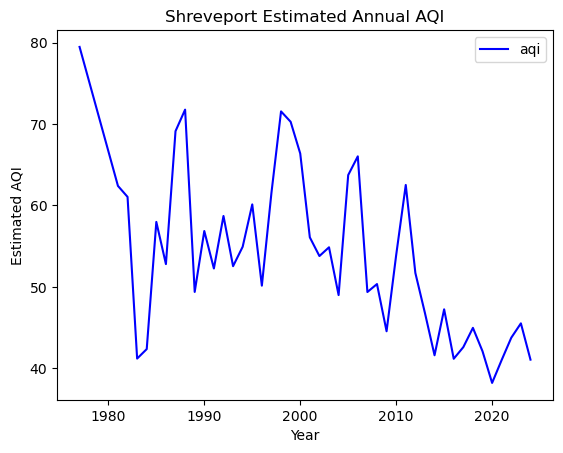

In [71]:
# Plotting Annual AQI
aqi_est_df_yearly.dropna().plot(x="year", y="aqi", color="b")
plt.title("Shreveport Estimated Annual AQI")
plt.xlabel("Year")
plt.ylabel("Estimated AQI")
plt.show()

# Part 2: Wildfire Smoke Estimation

With our reference AQI estimates now obtained, we can generate our own smoke estimates from the local wildfire data.

### Obtaining Wildfire Data

The wildfire data used in this analysis is sourced from the US Geological Survey's Wildland fire dataset. Specifically, this analysis will be performed with the `USGS_Wildland_Fire_Combined_Dataset` contained within the Wildland geodatabase file.

The full geodatabase file contains a dataset of unprocessed merged data from the Geological Survey's various sources (with redundant entries), a dataset of overlapping entries between its sources, and a fully cleaned "Combined" dataset. As this analysis has no need of the raw data, the combined dataset will be used.  

**NOTE**: This next line of code will expect there to be a folder titled `wildfire_data` containing the Wildland gdb file

In [31]:
# Reading in Wildland dataset
wildfire_gdf: gpd.GeoDataFrame = gpd.read_file("wildfire_data/Fire_Feature_Data.gdb", layer="USGS_Wildland_Fire_Combined_Dataset")
# Generating geospatial point for Shreveport
# (Please excuse the pun. I simply had to)
shrevepoint = Point(-93.763504, 32.523659)

C:\Users\bruno\miniconda3\Lib\site-packages\pyogrio\raw.py:198: RuntimeWarning: organizePolygons() received a polygon with more than 100 parts. The processing may be really slow.  You can skip the processing by setting METHOD=SKIP, or only make it analyze counter-clock wise parts by setting METHOD=ONLY_CCW if you can assume that the outline of holes is counter-clock wise defined
  return ogr_read(


This dataset contains data for the entire continental U.S. and is thus wildly excessive for our purposes. When making estimates of smoke impacts on Shreveport, we need only consider the relevant data. That being, data from the last 60 years, during the fire season, and within 650 miles of Shreveport itself.

In [32]:
# Restrict dataset to fires in the last 60 years
wildfire_gdf: gpd.GeoDataFrame = wildfire_gdf[wildfire_gdf['Fire_Year'] >= year_range[0]]

Throughout this analysis, two main reference systems will be used. When attempting to plot a set of coordinates onto a flat map, the default **EPSG 4326** coordinate system will be used as it is the coordinate system expected by geopandas' plotting functions (and the only coordinate system to which the Wildland dataset's ESRI format can be immediately converted to by geopandas). However, when calculating distances to estimate the spread of wildfire smoke, the **EPSG 5070** system will be used instead as it properly accounds for the curvature of the earth when making comparisons between points

In [33]:
# Converting dataset from ESRI to EPSG format
wildfire_gdf: gpd.GeoDataFrame = wildfire_gdf.to_crs(epsg=4326)
shrevepoint_epsg = gpd.GeoSeries([shrevepoint], crs="EPSG:4326")

In [44]:
# Calculating distance and converting to miles for parity with AQI dataset
wildfire_gdf["dist_epsg_5070"] = wildfire_gdf.to_crs(epsg=5070).distance(shrevepoint_epsg.to_crs(epsg=5070)[0]) * 0.000621371

In [45]:
# Storing list of fires from all distances for future analysis
wildfire_gdf_all_dist = wildfire_gdf.copy()
# Filtering out fires over 1046km (650mi) away
wildfire_gdf = wildfire_gdf[wildfire_gdf["dist_epsg_5070"] <= 650]

With the distances and years accounted for, the wildfire data must now be filtered for the fire season. As each entry in the dataset contains multiple date keys that could each be used to roughly estimate whether or not it occured during the fire season. In order to filter by this, we must take the latest fire end date available and the earliest fire start date available and ensure that they are less than October 31st and greater than May 1st respectively.

The following three functions perform these operations in a time-efficient manner. **See README for attribution.**

In [46]:
FIRE_FIRST_DATE_COL = 'Fire_First_Date'
FIRE_LAST_DATE_COL = 'Fire_Last_Date'

DEFAULT_FIRST_DD_MM = '05-01'
DEFAULT_LAST_DD_MM = '10-31'

FIRST_DATE_POSSIBLE_KEYS = [
    'Listed Ignition Date(s)',
    'Listed Wildfire Discovery Date(s)',
    'Listed Prescribed Fire Start Date(s)',
    'Prescribed Fire Start Date'
    'Listed Other Fire Date(s)'
]
first_date_keys_pattern = '|'.join(re.escape(key) for key in FIRST_DATE_POSSIBLE_KEYS)
first_date_pattern = rf'({first_date_keys_pattern}):\s*(\d{{4}}-\d{{2}}-\d{{2}})\b'

def get_first_dates(fire_feature_row, default_start_dd_mm=DEFAULT_FIRST_DD_MM, default_year=year_range[0]):
    """
    Get the start date of the fire from Listed_Fire_Dates.
    Currently, checks if any one of the date keys is in the list of FIRST_DATE_POSSIBLE_KEYS (in order).

    Parameters:
    ----------
    fire_feature_row (pd.Series): A row from the fire feature GeoDataFrame.

    default_start_dd_mm (str): The default start date (MM-DD) to use if no valid date is found.

    default_year (int): The default year to use if no valid date is found.
    
    Returns:
    ----------
    str: The first date of the fire feature.
    """
    # Check if the fire feature row has a valid date
    match = re.search(first_date_pattern, fire_feature_row['Listed_Fire_Dates'])

    date = None
    # If a match is found, return the date string
    if match:
        date = match.group(2)  # Group 2 captures the date
    else:
        date = f'{fire_feature_row['Fire_Year'] or default_year}-{default_start_dd_mm}'
    return date

LAST_DATE_POSSIBLE_KEYS = [
    'Listed Wildfire Controlled Date(s)',
    'Listed Wildfire Containment Date(s)'
    'Listed Wildfire Out Date(s)',
    'Prescribed Fire End Date',
]
last_date_keys_pattern = '|'.join(re.escape(key) for key in LAST_DATE_POSSIBLE_KEYS)
last_date_pattern = rf'({last_date_keys_pattern}):\s*(\d{{4}}-\d{{2}}-\d{{2}})\b'

def get_last_dates(fire_feature_row, default_end_dd_mm=DEFAULT_LAST_DD_MM, default_year=year_range[0]):
    """
    Get the end date of the fire from Listed_Fire_Dates.
    Currently, checks if any one of the date keys is in the list of LAST_DATE_POSSIBLE_KEYS (in order).

    Parameters:
    ----------
    fire_feature_row (pd.Series): A row from the fire feature GeoDataFrame.

    default_end_dd_mm (str): The default end date (MM-DD) to use if no valid date is found.

    default_year (int): The default year to use if no valid date is found.
    
    Returns:
    ----------
    str: The last date of the fire feature.
    """
    # Check if the fire feature row has a valid date
    match = re.search(last_date_pattern, fire_feature_row['Listed_Fire_Dates'])

    date = None
    # If a match is found, return the date string
    if match:
        date = match.group(2)  # Group 2 captures the date
    else:
        date = f'{fire_feature_row['Fire_Year'] or default_year}-{default_end_dd_mm}'
    return date

def overlap_with_fire_season(row):
    """
    Check if the fire overlaps with the fire season (May 1 - October 31).
    
    Parameters:
    ----------
    row (pd.Series): A row from the fire feature GeoDataFrame.
    
    Returns:
    ----------
    bool: True if the fire overlaps with the fire season, False otherwise.
    """
    fire_first_date = row[FIRE_FIRST_DATE_COL]
    fire_last_date = row[FIRE_LAST_DATE_COL]
    
    # Define the fire season start and end dates
    fire_season_start = pd.to_datetime(f'{row['Fire_Year']}-05-01')
    fire_season_end = pd.to_datetime(f'{row['Fire_Year']}-10-31')
    
    # Check for overlap
    return (fire_first_date <= fire_season_end) and (fire_last_date >= fire_season_start)

In [47]:
# Removing entries with no date data to pull from
wildfire_gdf = wildfire_gdf.dropna(subset='Listed_Fire_Dates')

In [48]:
# Applying the above sourced functions in order to obtain the first and last listed dates for each entry
wildfire_gdf[FIRE_FIRST_DATE_COL] = pd.to_datetime(wildfire_gdf.apply(get_first_dates, axis=1))
wildfire_gdf[FIRE_LAST_DATE_COL] = pd.to_datetime(wildfire_gdf.apply(get_last_dates, axis=1))

In [49]:
# Filtering for fire season entries
wildfire_gdf = wildfire_gdf[wildfire_gdf.apply(overlap_with_fire_season, axis=1)]

## Part 3: Modelling

#### Smoke Impact Modelling

In order to create an estimate of smoke impacts on Shreveport, we must first develop a rudimentary model for the relationship between smoke impact and nearby wildfires. The model for smoke impact must take into account factors in the dataset that are assumed to affect the severity of smoke on nearby cities. Within the wildland fire dataset these factors are the size of the fire, the distance of the fire from the town, and whether or not the fire was prescribed.

The size, or area, of a fire is directly proportional to how much smoke it will output as a larger burning surface area is a larger smoke-producing surface area.

By contrast, the distance of a fire from a city is inversely proportional to how much of its smoke we would expect to be able to reach it. In fact, if we assume that the smoke moves through passive diffusion, it is inversely proportional to the _square_ of its distance to the city.

Finally, we can take note of the fact that the wildland fire dataset contains both wildfires and prescribed, controlled fires. While both of these kinds of fires can be expected to generate similar amounts of smoke (controlling for size), it is reasonable to assume that controlled fires are typically performed with the aim of minimizing the impact on large populated areas. As such, we would expect the smoke impact to be proportional to how uncontrolled the fire is.

Very conviently for our model, the level of control a fire had is recorded as an ordinal variable where higher values indicate a more uncontrolled fire. Through this logic, we can create a rudimentary model where the smoke impact is the product of the fire area, the fire control value, and the square of the inverse of the distance to the city.

In [51]:
# Encoding ordinal fire control category into a numeric scale
fire_control_encoding = {"Wildfire": 5, "Likely Wildfire": 4,"Unknown - Likely Wildfire": 3,
                         "Unknown - Likely Prescribed Fire": 2, "Prescribed Fire": 1}
# Calculating smoke impact estimate
wildfire_gdf["smoke_impact_est"] = wildfire_gdf.Shape_Area * wildfire_gdf.Assigned_Fire_Type.map(fire_control_encoding) / (wildfire_gdf.dist_epsg_5070**2)

With a smoke impact score now assigned to every fire, the next step to estimate the annual smoke estimate from these individual fires.

While the smoke impact is meaningful enough on its own, our analysis aims to compare the annual time series behavior of AQI to the that of the calculated smoke estimate. In order to do this, the impact of each smoke estimate on the year's total smoke must itself be estimated. As there is no other data to pull from, the best estimate that can be made is that each fire's contribution toward annual smoke impact is proportional to both its individual smoke impact and its lifetime (active fire duration) as a proportion of the total fire season.

In [73]:
# Calculating the duration of each fire in days
wildfire_gdf["fire_duration_days"] = (wildfire_gdf.Fire_Last_Date - wildfire_gdf.Fire_First_Date).dt.days
# Scaling the smoke impact value by the proportion of the fire season that the fire lasted for
wildfire_gdf["smoke_impact_proportional"] = wildfire_gdf.smoke_impact_est * (wildfire_gdf.fire_duration_days / 183)
# Calculating the annual smoke impact estimate as the average proportial smoke impact value per year
wildfire_annual_smoke_impact_est_df = wildfire_gdf.groupby("Fire_Year").smoke_impact_proportional.mean().reset_index()

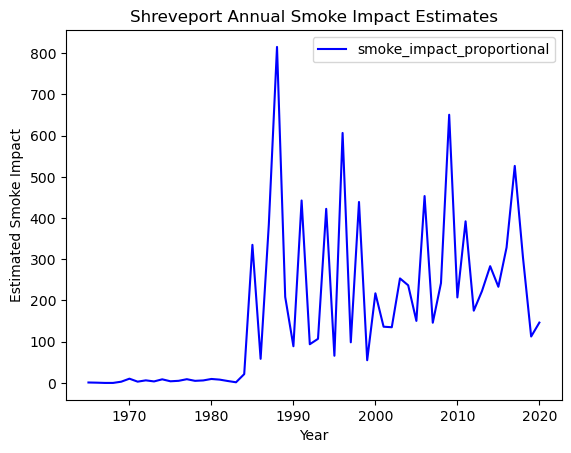

In [74]:
# Displaying annual smoke estimates
wildfire_annual_smoke_impact_est_df.plot(x="Fire_Year", y="smoke_impact_proportional", color='b')
plt.title("Shreveport Annual Smoke Impact Estimates")
plt.xlabel("Year")
plt.ylabel("Estimated Smoke Impact")
plt.show()

A cursory comparison of the smoke impact estimates plot above will show that it reflects a very different trend from the AQI estimates obtained earlier.

Whereas the AQI estimate has been steadily decreasing since the mid 1980s, the smoke impact estimate has been steadily increasing since then. While confusing at first glance, this is reasonable once one considers the fact that AQI measures _all_ air pollutant sources and not just forest fires. Indeed, this observation is further exacerbated by the fact that the frequency of fires across the U.S. has increased since the 80s. As such, the majority of polution measured by AQI before 1980 came from sources other than wildfires such as the many hazardous industrial practices of the time.

#### Time Series Forecasting

With our yearly estimates of both smoke impact and AQI obtained, we can now combine the two datasets by year in order to more easily compare and analyze them side-by-side. As part of this process, any years not present in both datasets will be dropped as they cannot be used for our contrasting analysis. This includes only the years before 1970.

In [100]:
# Merging annual datasets together
annual_est_df = pd.merge(wildfire_annual_smoke_impact_est_df, aqi_est_df_yearly, left_on="Fire_Year", right_on="year", how="inner")
# Imputing NaN values with 0 to make aqi's missing value format match that of the smoke impact estimate
# (and dropping redundant Fire_Year column)
annual_est_df = annual_est_df.drop("Fire_Year", axis=1).fillna(0)

With the smoke impact estimates and the AQI estimates nicely combined, we can now move on to developing a time series model that can forecast smoke impact estimates out into the next 25 years.

When implementing a time series model, it is worth noting that the majority of time series models require either an assumption of stationary behavior or an approximation of the non-stationary behavior underlying the data. As this a preliminary analysis, an assumption of stationary behavior will assumed and inspected during the analysis section.

Given the assumption of stationary behavior, a ARIMA model implemented through standard auto-ARIMA will be used .

In [109]:
# Training ARIMA model
smoke_ARIMA_model = pm.auto_arima(annual_est_df.smoke_impact_proportional, start_p=0, start_q=0, test='adf', stepwise=True)
# Generating smoke impact forecasts and confidence intervals for 25 years into the future
smoke_forecast, smoke_forecast_CI = smoke_ARIMA_model.predict(n_periods=25, return_conf_int=True)

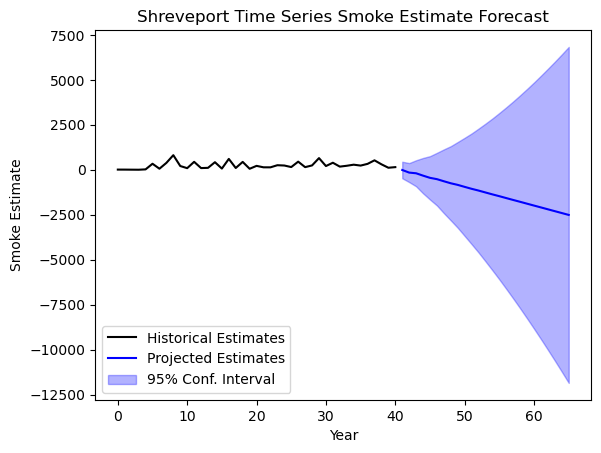

In [167]:
# Plotting forecast and uncertainty
plt.plot(annual_est_df.smoke_impact_proportional, color="k", label="Historical Estimates")
plt.plot(smoke_forecast, color="b", label="Projected Estimates")
plt.fill_between(smoke_forecast.index, smoke_forecast_CI[:,0], smoke_forecast_CI[:,1], color='b', alpha=.30 , label = "95% Conf. Interval")
plt.title("Shreveport Time Series Smoke Estimate Forecast")
plt.xlabel("Year")
plt.ylabel("Smoke Estimate")
plt.legend(loc="lower left")
plt.show()

The above plot shows the estimated smoke impact values generated by the time series model developed in the analysis. Along the x-axis, the plot shows the number of years since 1984. The year “40” in this plot indicates the present day. Along the y-axis, the plot shows the estimated smoke impact level generated by the time series model. This smoke impact level is calculated as a function of the area of all fires within 650 miles of Shreveport divided by the square of their distance to Shreveport, modeling the dispersion of smoke particles via passive diffusion.

The line in black shows the estimated smoke impact values in years for which we currently have data. The blue line shows the expected smoke value for future years, extrapolating the time series model out until 2049. The light-blue area shows the 95% confidence interval for the smoke impact estimates into the future. There is a 95% chance that the light-blue area shown contains the actual future estimate of smoke impact for that year
As can be seen, the time series forecast is highly questionable. The expected forecast trends negative, with the model predicting that all future years will have a smoke impact estimate of _less_ than 0. This value is incoherent and uninterpretable as negative smoke impact is not possible. The 95% confidence interval highlights the model's uncertainty through the fact that it encompasses a range of values nearly two orders of magnitude larger than the largest historical smoke impact estimate.

The previous plots of annual AQI and smoke impact already highlight the fact that these two values are _very_ poorly correlated. What is less obvious, however, is the fact that these smoke impact values are unlikely to be stationary.

The adf, or augmented Dickey-Fuller, test statistic used in the training of the ARIMA model to determine the presence of stationary behavior reports a p-value of 0.233 for the null hypothesis that the distribution of smoke impact is stationary. This does not give us good reason to suspect that the underlying smoke impact trends for Shreveport are stationary and are a likely cause for the time series model performing poorly on this.

Ultimately, either a better smoke statistic or a model for the non-stationary behavior within smoke impact will be needed to properly forecast the effect of wildfire smoke on Shreveport into the future..


## Part 4: Analysis

As a conclusion to this preliminary analysis into the effects and propagation of wildfire smoke on the city of Shreveport, three visual will be made highlighting the fire trends around the city.

#### Visual 1

Firstly, a plot of wildfire occurance as a function of distance from Shreveport

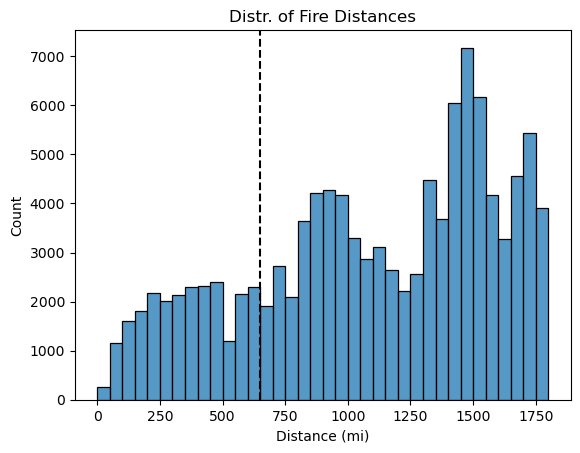

In [166]:
# Plotting histogram of wildland fire counts as a functon of distance from Shreveport
sns.histplot(data=wildfire_gdf_all_dist, x="dist_epsg_5070", bins=range(0, 1850, 50))
# Indicating the cutoff threshold used to filter for fires close to Shreveport in the model
plt.axvline(x=650, color='k', linestyle='--')
plt.title('Distr. of Fire Distances')
plt.xlabel('Distance (mi)')
plt.ylabel('Count')
plt.show()

The above plot shows the number of fires occurring as a function of distance from Shreveport for all fires up to 1800 miles away from the city. The x-axis provides the distance in miles from the city of Shreveport, separated into 50 mile segments. The y-axis provides the number of fires in the past 60 years that have occurred at that distance from the city.

Each blue column represents (through y-axis height) the number of fires that have occurred at a distance from the city that falls within the 50 mile distance range that each column takes up along the x-axis. The dashed black line through the left side of the plot denotes the 650 mile mark. This is the cutoff distance that was used to decide what data should be used to train a time series model to predict smoke pollution in Shreveport as a function of time. Only wildfires to the left of the dashed black line were included in the smoke model’s training dataset.


#### Visual 2

Secondly, a time series plot of yearly area burned by fires close to Shreveport (within 650 miles)

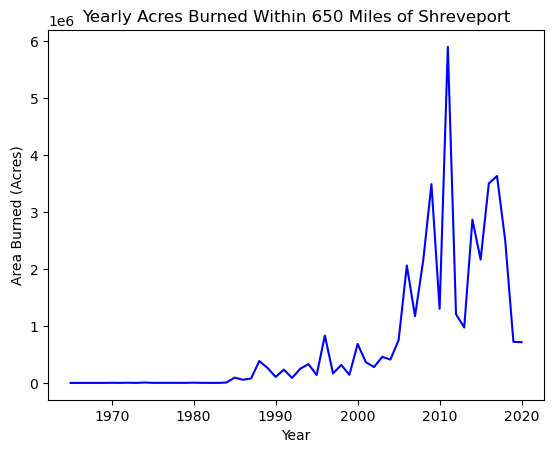

In [164]:
# Calculating yearly area burned around Shreveport
yearly_area_burned_df = wildfire_gdf.groupby("Fire_Year").GIS_Acres.sum().reset_index()
# Plotting yearly area burned around Shreveport
sns.lineplot(data=yearly_area_burned_df, x="Fire_Year", y="GIS_Acres", c='b')
plt.title('Yearly Acres Burned Within 650 Miles of Shreveport')
plt.xlabel('Year')
plt.ylabel('Area Burned (Acres)')
plt.show()

The above plot shows the known number of acres of land burned within 650 miles of Shreveport for each year in the past 60 years. The x-axis indicates the year being considered. The y-axis indicates the area of land (in acres) that burned within 650 miles of Shreveport during that year.

In this plot, high peaks represent a year in which a high amount of area burned within a 650 mile radius of Shreveport while low points represent a year in which Shreveport had little land burned around it within the same space. Points before 1984 that show no land simply represent the fact that the area of land burned around Shreveport was not well documented before 1984.


#### Visual 3

And lastly, a time series plot of both annual estimates smoke impact and annual estimated AQI

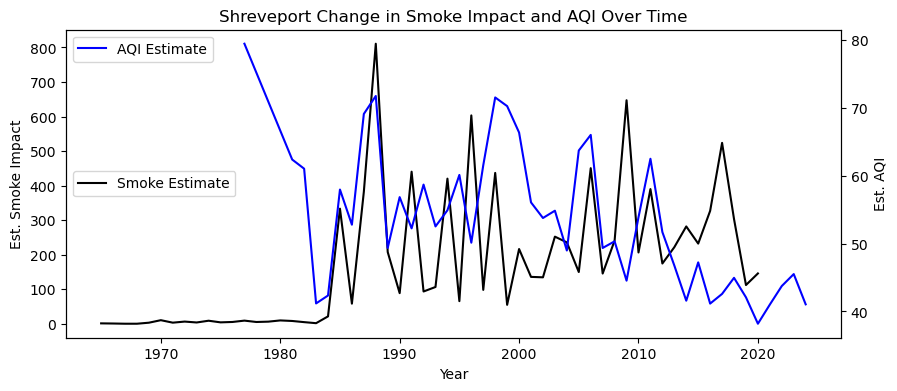

In [165]:
plt.figure(figsize=(10,4))
# Plotting annual smoke estimate data
ax = sns.lineplot(data=wildfire_annual_smoke_impact_est_df, x="Fire_Year", y="smoke_impact_proportional", color='k', label='Smoke Estimate')
plt.title('Shreveport Change in Smoke Impact and AQI Over Time')
plt.xlabel('Year')
plt.ylabel('Est. Smoke Impact')
plt.legend(loc="center left")
# Plotting annual AQI estimate data
sns.lineplot(data=aqi_annual_smoke_estimates_df, x="year", y="aqi", color='b', ax=ax.twinx(), label='AQI Estimate')
plt.ylabel('Est. AQI')
plt.legend(loc="upper left")
plt.show()

The above plot shows the smoke impact score and AQI over time for the city of Shreveport. The x-axis indicates the year being considered. The y-axis on the left of the plot indicates the estimated smoke impact in the city for any given year. The smoke impact value is an estimate of the amount that Shreveport was affected by smoke in that year. It was calculated by taking every fire that occurred within 650 miles of Shreveport and adding up their fire areas divided by the square of their distances to Shreveport. This calculation mimics the passive diffusion of smoke through the air.

The y-axis on the right of the plot indicates the estimated AQI in the city for any given year. AQI is a measure of air pollution created by measuring the proportion of various pollutants such as SO2 and CO in the air. The yearly estimate used in this plot was obtained by taking the highest AQI value for each day in a year for any of CO, SO2, NO2, or O2 across three different measuring stations, then obtaining the average of these daily values for each year.

When both AQI and smoke impact increase between years in tandem, it represents an increase in estimated pollution that occurred alongside an increase in estimated fire smoke.
